In [1]:
include("cosmology_vars.jl")
include("nu_osc_params.jl")

using DelimitedFiles
using Plots
using Interpolations
using LaTeXStrings
using QuadGK
using SpecialFunctions;

In [2]:
function F0_tint_func(F0vec::Vector{Float64})
    es = range(0, 100, 2000)
    F0int_ne = Interpolations.interpolate((vec(es),), F0vec, Gridded(Linear()))
    return extrapolate(F0int_ne, 0.0)
end

F0s_vec = readdlm("F0s_vec.txt", comments=true)

F0_νe_270sm, F0_νebar_270sm, F0_νx_270sm = F0_tint_func(vec(F0s_vec[:, 1])), F0_tint_func(vec(F0s_vec[:, 2])), F0_tint_func(vec(F0s_vec[:, 3]))
F0_νe_112sm, F0_νebar_112sm, F0_νx_112sm = F0_tint_func(vec(F0s_vec[:, 4])), F0_tint_func(vec(F0s_vec[:, 5])), F0_tint_func(vec(F0s_vec[:, 6]))
F0_νe_bh, F0_νebar_bh, F0_νx_bh = F0_tint_func(vec(F0s_vec[:, 7])), F0_tint_func(vec(F0s_vec[:, 8])), F0_tint_func(vec(F0s_vec[:, 9]))

function F0(E, β, sm)
    if β == "e" && sm == "small"
        return F0_νe_112sm(E)
    elseif β == "e" && sm == "large"
        return F0_νe_270sm(E)
    elseif β == "e" && sm == "bh"
        return F0_νe_bh(E)
    elseif β == "ebar" && sm == "small"
        return F0_νebar_112sm(E)
    elseif β == "ebar" && sm == "large"
        return F0_νebar_270sm(E)
    elseif β == "ebar" && sm == "bh"
        return F0_νebar_bh(E)   
    elseif β == "x" && sm == "small"
        return F0_νx_112sm(E)
    elseif β == "x" && sm == "large"
        return F0_νx_270sm(E)
    elseif β == "x" && sm == "bh"
        return F0_νx_bh(E)
    else
        return 0
    end
end

# Oscillations thru the SN medium
# Accounting for oscillations thru the SN medium

s12 = 0.297
c12 = 1 - s12
PH = 0

# ordering = "NO" (normal ordering) or "IO" (inverted ordering)
function F(E, β, sm, ordering)
    if ordering == "NO"
        if β == "e"
            return F0(E, "x", sm)
        elseif β == "ebar"
            return c12*F0(E, "ebar", sm) + s12*F0(E, "x", sm)
        elseif β == "x"
            return 0.5*(F0(E, "e", sm) + F0(E, "x", sm))
        elseif β == "xbar"
            return 0.5*(s12*F0(E, "ebar", sm) + (1 + c12)*F0(E, "x", sm))
        else
            return 0
        end
    elseif ordering == "IO"
        if β == "e"
            return s12*F0(E, "e", sm) + c12*F0(E, "x", sm)
        elseif β == "ebar"
            return F0(E, "x", sm)
        elseif β == "x"
            return 0.5*(c12*F0(E, "e", sm) + (1 + s12)*F0(E, "x", sm))
        elseif β == "xbar"
            return 0.5*(F0(E, "ebar", sm) + F0(E, "x", sm))
        else
            return 0
        end
    else
        return 0
    end
end

# In the mass basis now: i = 1, 2, 3, nubar = true or false
function Fmass(E, i, sm, ordering, nubar)
    if nubar==false
        return Usqred(ordering)[1, i]*F(E, "e", sm, ordering) + (1 - Usqred(ordering)[1, i])*F(E, "x", sm, ordering)
    elseif nubar==true
        return Usqred(ordering)[1, i]*F(E, "ebar", sm, ordering) + (1 - Usqred(ordering)[1, i])*F(E, "xbar", sm, ordering)
    else
        return 0
    end
end;

In [3]:
# We can take normchoice to be SNRnorm, SNRnorm_low, or SNRnorm_high
function DSNB_integrand(E, z0, z, i, nubar, ordering, bh_frac, normchoice)
    c0 = 3e8 # m s^(-1)
    if bh_frac == "21"
        return 0.00208 * (c0*normchoice*SFR(z)/Hubble(z)) * (ηAD(15, 8)*Fmass(E*(1+z)/(1+z0), i, "small", ordering, nubar) 
        + (ηAD(22, 15)+ηAD(27, 25))*Fmass(E*(1+z)/(1+z0), i, "large", ordering, nubar) + (ηAD(25, 22)+ηAD(125, 27))*Fmass(E*(1+z)/(1+z0), i, "bh", ordering, nubar))
    elseif bh_frac == "41"
        return 0.00208 * (c0*normchoice*SFR(z)/Hubble(z)) * (ηAD(15, 8)*Fmass(E*(1+z)/(1+z0), i, "small", ordering, nubar) 
        + ηAD(125, 15)*Fmass(E*(1+z)/(1+z0), i, "bh", ordering, nubar))
    elseif bh_frac == "09"
        return 0.00208 * (c0*normchoice*SFR(z)/Hubble(z)) * (ηAD(15, 8)*Fmass(E*(1+z)/(1+z0), i, "small", ordering, nubar)
        + ηAD(40, 15)*Fmass(E*(1+z)/(1+z0), i, "large", ordering, nubar) + ηAD(125, 40)*Fmass(E*(1+z)/(1+z0), i, "bh", ordering, nubar))
    else
        return 0
    end
end

DSNB(E, z0, i, nubar, ordering, bh_frac, normchoice) = 1/(1+z0) * quadgk(z -> DSNB_integrand(E, z0, z, i, nubar, ordering, bh_frac, normchoice), z0, 5, rtol=1e-2)[1]

DSNB (generic function with 1 method)

In [4]:
# Define this effective length function
LeffIntegrand(z) = (H0*sqrt(energy_matter*(1+z)^3 + energy_dark))^(-1)*(1+z)^(-2)

leff_quadint(z0) = quadgk(z -> LeffIntegrand(z), 0, z0)[1]

zs_leff = range(0, 5, 1000)
leff_ne = Interpolations.interpolate((vec(zs_leff),), leff_quadint.(zs_leff), Gridded(Linear()))
leff = extrapolate(leff_ne, 0.0)

function decay(E, α, z0, z)
    scalefactor = 4.68e28
    return exp(-scalefactor*α*(leff(z) - leff(z0))*(1+z0)/E)
end;

In [5]:
function DSNB_vdecay_3_NO(E, z0, α3, threebar, bh_frac, normchoice)
    function decay_integrand(E, z0, z, α3, threebar, bh_frac, normchoice)
        if α3 == 0
            return DSNB_integrand(E, z0, z, 3, threebar, "NO", bh_frac, normchoice)
        else
            int = DSNB_integrand(E, z0, z, 3, threebar, "NO", bh_frac, normchoice)*decay(E, α3, z0, z) 
            if isnan(int) || isinf(int)
                return 0.0
            else
                return int
            end
        end
    end
    return 1/(1+z0) * quadgk(z -> decay_integrand(E, z0, z, α3, threebar, bh_frac, normchoice), z0, 5, rtol=1e-2)[1]
end;

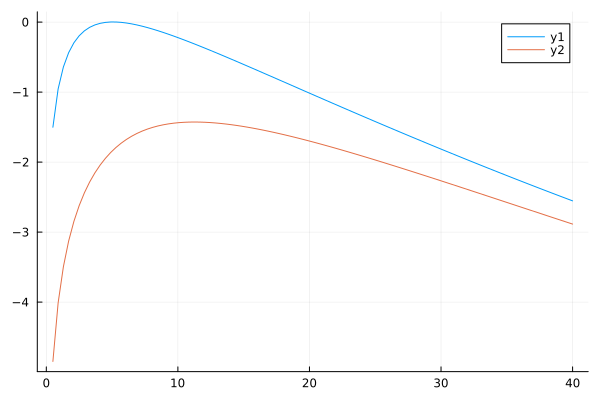

In [6]:
es_dsnb = range(0.5, 40, 100)
plot(es_dsnb, [log10.(DSNB_vdecay_3_NO.(es_dsnb, 1, 0, false, "21", SNRnorm)) log10.(DSNB_vdecay_3_NO.(es_dsnb, 1, 10^(-24), false, "21", SNRnorm))])

In [94]:
function ψSH(Eh, El, hc)
    if hc
        return 2*El/Eh^2
    else
        return (2/Eh)*(1-(El/Eh))
    end
end

function branch_3ν(j, i, ordering)
    if ordering == "NO"
        if j == 3
            return 0.25
        elseif j == 2
            return 0.5
        else
            return println("error: j is not a valid index")
        end
    elseif ordering == "IO"
        if j == 2
            return 0.25
        elseif j == 1
            return 0.5
        else
            return println("error: j is not a valid index")
        end
    else
        return println("error: ordering must be either 'NO' or 'IO'")
    end
end

function q3icontrib(E, z0, z, α3, threebar, i, ibar, bh_frac, normchoice)
    if threebar == ibar
        hc = true
    else
        hc = false
    end

    Ers = E*(1+z)/(1+z0)

    qnorm = 3.086e19 * 1.516e15 * 1e6 / (3e8 * 1e12)
    integrand(Eprime, z) = qnorm * (c0/Hubble(z))*DSNB_vdecay_3_NO(Eprime, z, α3, threebar, bh_frac, normchoice) * (α3 * branch_3ν(3, i, "NO")/Eprime) * ψSH(Eprime, Ers, hc)
    
    Emax = Ers + 50

    return quadgk(Eprime -> integrand(Eprime, z), Ers, Emax, rtol=1e-2)[1]

end;

function DSNB_vdecay_2_NO(E, z0, α3, α2, twobar, bh_frac, normchoice)
    integrand(z) = (DSNB_integrand(E, z0, z, 2, twobar, "NO", bh_frac, normchoice) +
                          q3icontrib(E, z0, z, α3, true, 2, twobar, bh_frac, normchoice) + q3icontrib(E, z0, z, α3, false, 2, twobar, bh_frac, normchoice))*decay(E, α2, z0, z)
    return (1/(1+z0)) * quadgk(z -> integrand(z), z0, 5, rtol=1e-2)[1]
end

function q21contrib(E, z0, z, α3, α2, twobar, onebar, bh_frac, normchoice)
    if twobar == onebar
        hc = true
    else
        hc = false
    end

    Ers = E*(1+z)/(1+z0)

    qnorm = 3.086e19 * 1.516e15 * 1e6 / (3e8 * 1e12)
    integrand(Eprime, z) = qnorm * (c0/Hubble(z))*DSNB_vdecay_2_NO(Eprime, z, α3, α2, twobar, bh_frac, normchoice) * (α2 * branch_3ν(2, 1, "NO")/Eprime) * ψSH(Eprime, Ers, hc)
    
    Emax = Ers + 50

    return quadgk(Eprime -> integrand(Eprime, z), Ers, Emax, rtol=1e-2)[1]

end

# z0 is always 0 here because we're only concerned with the flux at Earth
function DSNB_vdecay_1_NO(E, α3, α2, onebar, bh_frac, normchoice)
    integrand(z) = (DSNB_integrand(E, 0, z, 1, onebar, "NO", bh_frac, normchoice)
                    + q21contrib(E, 0, z, α3, α2, true, onebar, bh_frac, normchoice)
                    + q21contrib(E, 0, z, α3, α2, false, onebar, bh_frac, normchoice)
                    + q3icontrib(E, 0, z, α3, true, 1, onebar, bh_frac, normchoice)
                    + q3icontrib(E, 0, z, α3, false, 1, onebar, bh_frac, normchoice))

    return quadgk(z -> integrand(z), 0, 5, rtol=1e-2)[1]
end

DSNB_vdecay_1_NO (generic function with 1 method)

In [61]:
@time DSNB_vdecay_2_NO(7, 0, 0, 0, true, "21", SNRnorm)

  0.328799 seconds (3.14 M allocations: 48.613 MiB, 39.84% gc time)


1.0793210353250817

In [95]:
@time DSNB_vdecay_1_NO(1, 10^(-25), 10^(-25), true, "21", SNRnorm)

372.726137 seconds (2.70 G allocations: 52.681 GiB, 8.91% gc time, 53.76% compilation time)


8.14333841213382

In [85]:
@time q21contrib(1, 1, 2, 10^(-25), 10^(-25), false, false, "21", SNRnorm)

  7.961052 seconds (83.90 M allocations: 1.262 GiB, 6.79% gc time)


0.580279139617933